In [25]:
# Install Java
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Download Spark 3.5.1 from an official mirror
!wget -q https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz

# Extract the archive
!tar -xzf spark-3.5.1-bin-hadoop3.tgz

# Install PySpark and findspark
!pip install -q pyspark findspark
!pip install umap-learn

In [26]:
import os
import json
import warnings
import psutil
import findspark
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, concat_ws, length, regexp_replace
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap.umap_ as umap
from google.colab import drive

In [27]:
def create_spark_session(app_name="EDGARAnalysis", driver_memory="8g"):
    """Create optimized Spark session"""
    spark = SparkSession.builder \
        .appName(app_name) \
        .config("spark.driver.memory", driver_memory) \
        .config("spark.driver.maxResultSize", "4g") \
        .config("spark.sql.shuffle.partitions", "100") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .config("spark.sql.adaptive.enabled", "true") \
        .getOrCreate()

    print(f"Spark session created with {driver_memory} driver memory")
    print(f"Available RAM: {round(psutil.virtual_memory().available / 1e9, 2)} GB")
    return spark

In [28]:
def mount_google_drive():
    """Mount Google Drive for data access"""
    try:
        drive.mount('/content/drive')
        print("Google Drive mounted successfully")
        return True
    except Exception as e:
        print(f"Error mounting drive: {e}")
        return False

In [29]:
def load_edgar_parquet_data(spark, years: List[int], base_path: str):
    """Load and combine EDGAR data from multiple years"""
    print(f"Loading EDGAR data for years: {years}")
    dfs = []

    for year in years:
        path = os.path.join(base_path, f"edgar_pandas_{year}.parquet")
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue

        try:
            df = spark.read.parquet(path).withColumn("year", lit(year))
            count = df.count()
            print(f" Loaded {count} records for year {year}")
            dfs.append(df)
        except Exception as e:
            print(f"Error loading {year}: {e}")
            continue

    if not dfs:
        print("No data loaded successfully")
        return None

    # Union all dataframes
    combined_df = dfs[0]
    for df in dfs[1:]:
        combined_df = combined_df.unionByName(df, allowMissingColumns=True)

    total_count = combined_df.count()
    print(f" Combined dataset: {total_count} total records")
    return combined_df

In [30]:
def select_largest_company(df, year: int = 2020):
    """Select company with largest combined section text for given year"""
    print(f"Selecting company with largest 10-K text for year {year}")

    year_df = df.filter(col("year") == year)

    # Calculate text length safely
    df_with_len = year_df.withColumn(
        "section_1_clean", regexp_replace(col("section_1"), r'\s+', ' ')
    ).withColumn(
        "section_7_clean", regexp_replace(col("section_7"), r'\s+', ' ')
    ).withColumn(
        "total_text_len",
        length(col("section_1_clean")) + length(col("section_7_clean"))
    )

    top_company = df_with_len.orderBy(col("total_text_len").desc()).first()

    if top_company:
        cik = top_company["cik"]
        # Access company_name using dictionary-style access after converting to dict
        top_company_dict = top_company.asDict()
        company_name = top_company_dict.get("company_name", "Unknown")
        text_len = top_company["total_text_len"]

        print(f"Selected Company: {company_name} (CIK: {cik})")
        print(f"Total text length: {text_len:,} characters")

        # Filter for this company and create full_text column
        filtered_df = year_df.filter(col("cik") == cik) \
            .withColumn("full_text", concat_ws("\n\n", col("section_1"), col("section_7")))

        return filtered_df, cik, company_name

    print(f"No company found for year {year}")
    return None, None, None

In [31]:
def create_enhanced_chunks(pandas_df: pd.DataFrame,
                          chunk_size: int = 1200,
                          overlap: int = 300,
                          min_chunk_size: int = 100) -> pd.DataFrame:
    """Create enhanced text chunks with metadata and overlap"""
    print(f"Creating chunks (size: {chunk_size}, overlap: {overlap})")

    chunks = []
    for idx, row in pandas_df.iterrows():
        text = row['full_text']
        if not text or len(text.strip()) < min_chunk_size:
            continue

        # Clean and normalize text
        text = ' '.join(text.split())  # Remove extra whitespace

        # Create overlapping chunks
        start = 0
        chunk_id = 0
        while start < len(text):
            end = min(start + chunk_size, len(text))
            chunk_text = text[start:end]

            # Skip very small chunks at the end
            if len(chunk_text.strip()) < min_chunk_size:
                break

            chunks.append({
                "cik": row["cik"],
                "filename": row["filename"],
                "year": row.get("year", 2020),
                "chunk_id": chunk_id,
                "chunk_text": chunk_text,
                "chunk_start": start,
                "chunk_end": end,
                "chunk_length": len(chunk_text)
            })

            chunk_id += 1
            # Move start position with overlap
            start += chunk_size - overlap

    chunk_df = pd.DataFrame(chunks)
    print(f"Created {len(chunk_df)} chunks from {len(pandas_df)} documents")

    # Display statistics
    if len(chunk_df) > 0:
        print(f"  Chunk statistics:")
        print(f"   Mean length: {chunk_df['chunk_length'].mean():.0f} characters")
        print(f"   Std length: {chunk_df['chunk_length'].std():.0f} characters")
        print(f"   Min length: {chunk_df['chunk_length'].min()} characters")
        print(f"   Max length: {chunk_df['chunk_length'].max()} characters")

    return chunk_df

In [32]:
def generate_sentence_embeddings(chunk_df: pd.DataFrame,
                               model_name: str = 'all-MiniLM-L6-v2') -> pd.DataFrame:
    """Generate sentence embeddings for all chunks"""
    print(f"Generating embeddings using model: {model_name}")

    model = SentenceTransformer(model_name)

    # Extract text for embedding
    texts = chunk_df["chunk_text"].tolist()
    print(f" Processing {len(texts)} text chunks...")

    # Generate embeddings in batches
    embeddings = model.encode(texts, batch_size=32, show_progress_bar=True)

    # Add embeddings to dataframe
    chunk_df = chunk_df.copy()
    chunk_df["embedding"] = list(embeddings)

    print(f"Generated embeddings shape: {embeddings.shape}")
    return chunk_df, model

In [33]:
def reduce_embedding_dimensions(chunk_df: pd.DataFrame, method: str = "umap") -> pd.DataFrame:
    """Reduce embedding dimensions for visualization"""
    print(f"Reducing dimensions using {method.upper()}")

    embeddings = np.vstack(chunk_df["embedding"].values)
    print(f"Original embedding shape: {embeddings.shape}")

    # Standardize embeddings
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)

    # Apply dimensionality reduction
    if method.lower() == "pca":
        reducer = PCA(n_components=2, random_state=42)
    else:  # UMAP
        reducer = umap.UMAP(n_components=2, random_state=42,
                          n_neighbors=15, min_dist=0.1)

    reduced = reducer.fit_transform(scaled_embeddings)

    # Add reduced dimensions to dataframe
    chunk_df = chunk_df.copy()
    chunk_df["x"] = reduced[:, 0]
    chunk_df["y"] = reduced[:, 1]

    print(f"Reduced to 2D: {reduced.shape}")
    return chunk_df

In [34]:
def create_validation_dataset(target_attributes: List[str]) -> Dict:
    """Create validation dataset with ground truth for 5 attributes"""
    print("Creating validation dataset with ground truth...")

    validation_dataset = {
        "Company Name and Business Description": {
            "query": "What is the company name and primary business description?",
            "expected_chunks": [0, 1, 2, 3, 4],  # Usually in first chunks
            "ground_truth": "Company name, headquarters location, and main business activities"
        },
        "Primary Risk Factors": {
            "query": "What are the major risk factors and business risks facing the company?",
            "expected_chunks": list(range(10, 35)),  # Risk factors typically mid-document
            "ground_truth": "Competition, regulatory changes, market volatility, operational risks"
        },
        "Annual Revenue and Financial Performance": {
            "query": "What is the company's annual revenue and key financial metrics?",
            "expected_chunks": list(range(5, 25)),  # Financial data scattered
            "ground_truth": "Total revenue, net income, earnings per share, growth rates"
        },
        "Main Business Segments": {
            "query": "What are the company's main business segments and operating divisions?",
            "expected_chunks": list(range(0, 20)),  # Business description early
            "ground_truth": "Primary business units, product lines, service offerings"
        },
        "Geographic Market Presence": {
            "query": "What is the company's geographic footprint and international operations?",
            "expected_chunks": list(range(0, 30)),  # Can be anywhere
            "ground_truth": "Domestic and international markets, regional operations, global presence"
        }
    }

    # Filter validation data based on requested attributes
    filtered_validation = {}
    for attr in target_attributes:
        if attr in validation_dataset:
            filtered_validation[attr] = validation_dataset[attr]
        else:
            # Create generic validation for custom attributes
            filtered_validation[attr] = {
                "query": f"What information is available about {attr}?",
                "expected_chunks": list(range(0, 15)),
                "ground_truth": f"Information about {attr} from SEC filing"
            }

    print(f"Created validation dataset for {len(filtered_validation)} attributes")
    return filtered_validation

In [35]:
def perform_semantic_search(query: str, chunk_df: pd.DataFrame,
                          model: SentenceTransformer, top_k: int = 5) -> pd.DataFrame:
    """Perform semantic search to retrieve most relevant chunks"""
    print(f"Searching for: '{query[:50]}...'")

    # Generate query embedding
    query_embedding = model.encode([query])

    # Calculate cosine similarities
    chunk_embeddings = np.vstack(chunk_df["embedding"].values)
    similarities = cosine_similarity(query_embedding, chunk_embeddings)[0]

    # Add similarity scores and sort
    result_df = chunk_df.copy()
    result_df["similarity"] = similarities
    result_df = result_df.sort_values("similarity", ascending=False).head(top_k)

    print(f"Retrieved top {len(result_df)} chunks")
    return result_df

In [36]:
def evaluate_retrieval_accuracy(retrieved_chunks: pd.DataFrame,
                              expected_chunks: List[int]) -> Dict:
    """Evaluate retrieval accuracy using precision, recall, F1"""
    retrieved_ids = set(retrieved_chunks["chunk_id"].tolist())
    expected_ids = set(expected_chunks)

    # Calculate intersection
    intersection = retrieved_ids.intersection(expected_ids)

    # Calculate metrics
    precision = len(intersection) / len(retrieved_ids) if retrieved_ids else 0
    recall = len(intersection) / len(expected_ids) if expected_ids else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    metrics = {
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "retrieved_chunks": list(retrieved_ids),
        "expected_chunks": list(expected_ids),
        "intersection": list(intersection),
        "num_retrieved": len(retrieved_ids),
        "num_expected": len(expected_ids),
        "num_intersection": len(intersection)
    }

    return metrics

In [37]:
def build_llm_extraction_prompt(chunks: List[str], attributes: List[str]) -> str:
    """Build structured prompt for LLM attribute extraction"""
    # Format chunks with clear separation
    context = "\n\n".join([f"--- CHUNK {i+1} ---\n{chunk}" for i, chunk in enumerate(chunks)])

    # Create attribute list
    attr_list = "\n".join([f"{i+1}. {attr}" for i, attr in enumerate(attributes)])

    prompt = f"""You are analyzing excerpts from a company's SEC 10-K filing. Extract specific business information from the provided document chunks.

DOCUMENT EXCERPTS:
{context}

EXTRACTION TASK:
Please extract the following business attributes with specific, factual information:

{attr_list}

INSTRUCTIONS:
- Provide specific facts, numbers, dates, and details when available
- Quote relevant text snippets to support your findings
- If information is not found in the excerpts, state "Not found in provided text"
- Focus on concrete, factual content rather than general statements
- Include context and supporting details for each attribute

RESPONSE FORMAT:
Return your analysis as a JSON object with this exact structure:
{json.dumps({attr: {"value": "extracted information", "source_chunk": "chunk number", "confidence": "high/medium/low"} for attr in attributes}, indent=2)}

JSON Response:"""

    return prompt

In [38]:
def visualize_chunk_embeddings(chunk_df: pd.DataFrame, title: str = "Document Chunks in Embedding Space"):
    """Create 2D visualization of chunk embeddings"""
    plt.figure(figsize=(12, 8))

    # Create scatter plot
    scatter = plt.scatter(chunk_df["x"], chunk_df["y"],
                         c=chunk_df["chunk_id"],
                         cmap='viridis',
                         alpha=0.7,
                         s=60,
                         edgecolors='white',
                         linewidth=0.5)

    plt.colorbar(scatter, label='Chunk ID')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('UMAP Dimension 1', fontsize=12)
    plt.ylabel('UMAP Dimension 2', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Add some statistics as text
    plt.figtext(0.02, 0.02, f"Total chunks: {len(chunk_df)}", fontsize=10)

    plt.show()

In [39]:
def run_complete_edgar_analysis(years: List[int], base_path: str, target_attributes: List[str]):
    """Run the complete EDGAR analysis pipeline"""
    print("Starting Enhanced EDGAR 10-K Analysis Pipeline")
    print("="*80)

    results = {}
    spark = None

    try:
        # Step 1: Setup
        print("\nSTEP 1: Environment Setup")
        if not mount_google_drive():
            return None

        spark = create_spark_session()

        # Step 2: Data Loading
        print("\nSTEP 2: Data Loading")
        full_df = load_edgar_parquet_data(spark, years, base_path)
        if full_df is None:
            print("Failed to load data")
            return None

        # Step 3: Company Selection
        print("\nSTEP 3: Company Selection")
        filtered_df, cik, company_name = select_largest_company(full_df, 2020)
        if filtered_df is None:
            print("Failed to select company")
            return None

        # Step 4: Data Conversion and Chunking
        print("\nSTEP 4: Document Chunking")
        pandas_df = filtered_df.select("cik", "filename", "full_text", "year").toPandas()
        print(f"Processing {len(pandas_df)} documents for {company_name}")

        chunk_df = create_enhanced_chunks(pandas_df, chunk_size=1200, overlap=300)

        if len(chunk_df) == 0:
            print("No chunks created")
            return None

        # Step 5: Embedding Generation
        print("\nSTEP 5: Embedding Generation")
        chunk_df, model = generate_sentence_embeddings(chunk_df)

        # Step 6: Dimensionality Reduction
        print("\nSTEP 6: Dimensionality Reduction")
        chunk_df = reduce_embedding_dimensions(chunk_df, method="umap")

        # Step 7: Visualization
        print("\nSTEP 7: Visualization")
        visualize_chunk_embeddings(chunk_df, f"Embeddings for {company_name} (CIK: {cik})")

        # Step 8: Validation Dataset
        print("\nSTEP 8: Validation Dataset Creation")
        validation_data = create_validation_dataset(target_attributes)

        # Step 9: Semantic Search & Validation
        print("\nSTEP 9: Semantic Search & Retrieval Validation")
        print("="*60)

        all_metrics = []

        for attribute, validation_info in validation_data.items():
            print(f"\nATTRIBUTE: {attribute.upper()}")
            print("-" * 50)

            query = validation_info["query"]
            expected_chunks = validation_info["expected_chunks"]
            ground_truth = validation_info["ground_truth"]

            print(f"Query: {query}")
            print(f"Expected ground truth: {ground_truth}")

            # Perform semantic search
            top_chunks = perform_semantic_search(query, chunk_df, model, top_k=5)

            # Evaluate retrieval accuracy
            metrics = evaluate_retrieval_accuracy(top_chunks, expected_chunks)
            all_metrics.append(metrics)

            print(f"\nRetrieval Performance:")
            print(f"   Precision: {metrics['precision']:.3f}")
            print(f"   Recall: {metrics['recall']:.3f}")
            print(f"   F1-Score: {metrics['f1_score']:.3f}")
            print(f"   Retrieved: {metrics['num_intersection']}/{metrics['num_retrieved']} chunks")

            print(f"\nTop Retrieved Chunks:")
            for i, (_, row) in enumerate(top_chunks.iterrows()):
                print(f"   Chunk {row['chunk_id']} (Score: {row['similarity']:.4f}):")
                preview = row['chunk_text'].replace('\n', ' ')[:150]
                print(f"   \"{preview}...\"\n")

            # Generate LLM prompt
            extraction_prompt = build_llm_extraction_prompt(
                top_chunks["chunk_text"].tolist()[:3],
                [attribute]
            )

            # Store results
            results[attribute] = {
                "query": query,
                "ground_truth": ground_truth,
                "top_chunks": top_chunks,
                "metrics": metrics,
                "extraction_prompt": extraction_prompt
            }

            print(f"Generated LLM Prompt Preview:")
            print(f"   {extraction_prompt[:200]}...\n")

        # Step 10: Final Summary
        print("\n" + "="*80)
        print("FINAL ANALYSIS SUMMARY")
        print("="*80)

        avg_precision = np.mean([m["precision"] for m in all_metrics])
        avg_recall = np.mean([m["recall"] for m in all_metrics])
        avg_f1 = np.mean([m["f1_score"] for m in all_metrics])

        print(f"Company: {company_name} (CIK: {cik})")
        print(f"Total chunks created: {len(chunk_df)}")
        print(f"Attributes analyzed: {len(target_attributes)}")
        print(f"Average chunk length: {chunk_df['chunk_length'].mean():.0f} characters")
        print(f"Average retrieval performance:")
        print(f"   Precision: {avg_precision:.3f}")
        print(f"   Recall: {avg_recall:.3f}")
        print(f"   F1-Score: {avg_f1:.3f}")

        # Add chunk dataframe to results for further analysis
        results["metadata"] = {
            "company_name": company_name,
            "cik": cik,
            "total_chunks": len(chunk_df),
            "chunk_df": chunk_df,
            "model": model,
            "avg_metrics": {
                "precision": avg_precision,
                "recall": avg_recall,
                "f1_score": avg_f1
            }
        }

        print("\nAnalysis completed successfully!")
        return results

    except Exception as e:
        print(f"\nAnalysis failed with error: {e}")
        import traceback
        traceback.print_exc()
        return None

    finally:
        if spark:
            spark.stop()
            print("🔌 Spark session closed")

In [40]:
def main():
    """Main execution function"""

    # Configuration
    YEARS = [2018, 2019, 2020]
    BASE_PATH = "/content/drive/MyDrive/edgar_data"

    # Define 5 target attributes for extraction
    TARGET_ATTRIBUTES = [
        "Company Name and Business Description",
        "Primary Risk Factors",
        "Annual Revenue and Financial Performance",
        "Main Business Segments",
        "Geographic Market Presence"
    ]

    print("Target Attributes:")
    for i, attr in enumerate(TARGET_ATTRIBUTES, 1):
        print(f"   {i}. {attr}")

    # Run complete analysis
    results = run_complete_edgar_analysis(YEARS, BASE_PATH, TARGET_ATTRIBUTES)

    if results:
        print("\nAnalysis completed! Results available in 'results' variable.")

        # Example: Show one extraction prompt
        sample_attr = TARGET_ATTRIBUTES[0]
        if sample_attr in results:
            sample_prompt = results[sample_attr]["extraction_prompt"]
            print(f"\nSample extraction prompt for '{sample_attr}':")
            print("="*60)
            print(sample_prompt[:800] + "..." if len(sample_prompt) > 800 else sample_prompt)

    return results

Target Attributes:
   1. Company Name and Business Description
   2. Primary Risk Factors
   3. Annual Revenue and Financial Performance
   4. Main Business Segments
   5. Geographic Market Presence
Starting Enhanced EDGAR 10-K Analysis Pipeline

STEP 1: Environment Setup
Mounted at /content/drive
Google Drive mounted successfully
Spark session created with 8g driver memory
Available RAM: 10.92 GB

STEP 2: Data Loading
Loading EDGAR data for years: [2018, 2019, 2020]
 Loaded 5508 records for year 2018
 Loaded 5354 records for year 2019
 Loaded 5480 records for year 2020
 Combined dataset: 16342 total records

STEP 3: Company Selection
Selecting company with largest 10-K text for year 2020
Selected Company: Unknown (CIK: 310522)
Total text length: 493,615 characters

STEP 4: Document Chunking
Processing 1 documents for Unknown
Creating chunks (size: 1200, overlap: 300)
Created 549 chunks from 1 documents
  Chunk statistics:
   Mean length: 1199 characters
   Std length: 33 characters
  

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

 Processing 549 text chunks...


Batches:   0%|          | 0/18 [00:00<?, ?it/s]

Generated embeddings shape: (549, 384)

STEP 6: Dimensionality Reduction
Reducing dimensions using UMAP
Original embedding shape: (549, 384)
Reduced to 2D: (549, 2)

STEP 7: Visualization


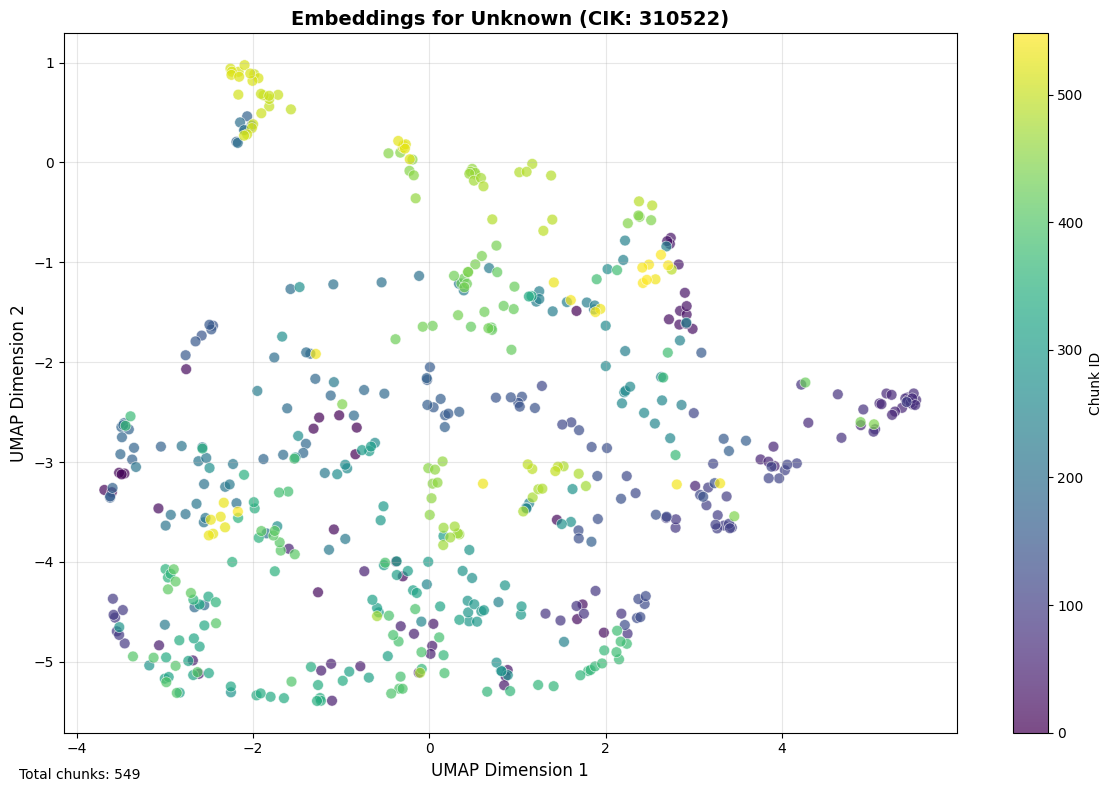


STEP 8: Validation Dataset Creation
Creating validation dataset with ground truth...
Created validation dataset for 5 attributes

STEP 9: Semantic Search & Retrieval Validation

ATTRIBUTE: COMPANY NAME AND BUSINESS DESCRIPTION
--------------------------------------------------
Query: What is the company name and primary business description?
Expected ground truth: Company name, headquarters location, and main business activities
Searching for: 'What is the company name and primary business desc...'
Retrieved top 5 chunks

Retrieval Performance:
   Precision: 0.000
   Recall: 0.000
   F1-Score: 0.000
   Retrieved: 0/5 chunks

Top Retrieved Chunks:
   Chunk 245 (Score: 0.3779):
   "mortgage loans, which are secured by properties containing five or more residential units. The chart below displays the net revenues and net income fo..."

   Chunk 262 (Score: 0.3219):
   "he significant increase in 2020 compared with 2019 was driven by a very high volume of refinance activity due to histori

In [41]:
analysis_results = main()